# How to disable streaming for models that don't support it

Certain LLM models do not support streaming - perhaps most noticeably the new (depending on when you're reading this) o1 models from OpenAI. This can break LangGraph when using `astream_events` since under the hood, LangGraph is calling all the models in streaming mode. Let's see how this would cause an error by defining the simplest graph we can:

In [1]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

llm = ChatOpenAI(model="o1-preview",temperature=1)

graph_builder = StateGraph(MessagesState)

def chatbot(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

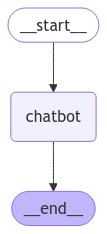

In [7]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Without disabling streaming

Let's try to call `astream_events` on our graph without disabling streaming, and see what happens:

In [2]:
input = {"messages": {"role":"user", "content":"how many r's are in strawberry?"}}
async for event in graph.astream_events(input, version="v2"):
    if event["event"] == "on_chat_model_end":
        print(event["data"]["output"].content, end="", flush=True)

BadRequestError: Error code: 400 - {'error': {'message': "Unsupported value: 'stream' does not support true with this model. Only the default (false) value is supported.", 'type': 'invalid_request_error', 'param': 'stream', 'code': 'unsupported_value'}}

An error occurred as we expected, luckily there is an easy fix!

## Disabling streaming

Now without making any changse to our graph, let's set the `disable_streaming` parameter on our model to be `True` which will solve our issues:

In [9]:
llm = ChatOpenAI(model="o1-preview",temperature=1,disable_streaming=True)

graph_builder = StateGraph(MessagesState)

def chatbot(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

And now, rerunning with the same input, we should see no errors:

In [18]:
input = {"messages": {"role":"user", "content":"how many r's are in strawberry?"}}
async for event in graph.astream_events(input, version="v2"):
    if event["event"] == "on_chat_model_end":
        print(event["data"]["output"].content, end="", flush=True)

There are **three** letter "r"s in the word "strawberry."

Here's the breakdown:

- **S**
- **T**
- **R** (1st "r")
- **A**
- **W**
- **B**
- **E**
- **R** (2nd "r")
- **R** (3rd "r")
- **Y**

So, the letters "r" appear in the 3rd, 8th, and 9th positions of the word "strawberry."